In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/captcha/mds-misis-dl-captchan/sample_submission.csv
/kaggle/input/captcha/mds-misis-dl-captchan/images.npy
/kaggle/input/captcha/mds-misis-dl-captchan/labels.npy
/kaggle/input/captcha/mds-misis-dl-captchan/images_sub.npy


## Описание

В этом соревновании вам предлагается задача из области компьютерного зрения – распознавание букв английского алфавита на искаженных и зашумленных изображениях.

Данные для обучения содержатся в двух файлах: images.npy и labels.npy. Это формат numpy-массивов.

Всего доступно 20 тысяч размеченных изображений размером 48x48 с 3 цветовыми каналами (RGB), поэтому массив images имеет размер (20000, 48, 48, 3). В массиве labels содержатся ответы к тренировочному набору изображений. В английском алфавите 26 букв: 0-й класс соответствует букве А и так далее по алфавиту, 25-й класс — буква Z.

Ваша задача — обучить нейронную сеть и с ее помощью предсказать метки классов для изображений из файла images_sub.npy, в нем 50 тысяч изображений. Посмотрите на структуру файла sample_submission.csv — он не содержит полезных данных, а лишь описывает формат, в котором вы загружаете ваши предсказания на сайт. Создайте из ваших предсказаний такой же файл и загрузите в качестве вашего ответа (сабмита). Вы можете делать до 20 сабмитов в сутки.
Метрика лидерборда — accuracy, то есть доля правильно распознанных изображений.

Задача будет считаться решенной, если в Public Leaderboard вы наберете score, который будет равен или больше 0.82.

## Описание данных

- images.npy - изображения для обучения
- labels.npy - метки для обучения
- sample_submission.csv - формат файла для сабмита
- images_sub.npy - изображения для сабмита

In [40]:
# Data loading
import numpy as np

images = np.load('/kaggle/input/captcha/mds-misis-dl-captchan/images.npy')
labels = np.load('/kaggle/input/captcha/mds-misis-dl-captchan/labels.npy')

## Data visualization

In [ ]:
import string
import matplotlib.pyplot as plt

letters = string.ascii_uppercase
alphabet_list = list(letters)
n_classes = len(letters)

print("Number of classes: ", n_classes)
print(letters)

## Data Loader

In [42]:
import torch
import torchvision
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

class NpyImagesDataset(Dataset):
    def __init__(self, images_npy, labels_npy='', transform=None):
        """
        Конструктор для класса NpyImagesDataset.

        :param images_npy: Путь к .npy файлу с изображениями
        :param labels_npy: Путь к .npy файлу с метками (опционально)
        :param transform: Трансформации, которые нужно применить к изображениям (опционально)
        """
        self.transform = transform
        self.images = np.load(images_npy)      # Loading images from a .npy file
        
        if labels_npy:
            self.labels = np.load(labels_npy)  # Load tags from the .npy file if the path is specified
        else:
            self.labels = None
  
    def __len__(self):
        """
        Возвращает количество изображений в наборе данных.

        :return: Количество изображений
        """
        return len(self.images)   
    
    def get_label(self, index):
        """
        Возвращает метку для указанного индекса.

        :param index: Индекс изображения
        :return: Метка изображения или 0, если метки не загружены
        """
        if self.labels is not None:
            return self.labels[index]
        return 0

    def __getitem__(self, index):
        """
        Возвращает изображение и его метку по указанному индексу.

        :param index: Индекс изображения
        :return: Кортеж (изображение, метка)
        """
        image = self.images[index]
        if self.transform is not None:
            image = self.transform(image)    # Apply transformations if specified
        return image, self.get_label(index)  # Returning the image and its label

In [43]:
import torchvision.transforms as transforms
import numpy as np

alex_net_image_size = 227

class PerImageNormalization(object):
    def __call__(self, tensor_image):
        """
        Нормализация каждого изображения по отдельности.

        :param tensor_image: Тензор изображения
        :return: Нормализованный тензор
        """
        mean, std = tensor_image.mean([1, 2]), tensor_image.std([1, 2]) # Calculate the average and standard deviation by channel
        normalize = transforms.Normalize(mean=mean, std=std)            # Create a Normalize object with the calculated values
        return normalize(tensor_image)                                  # Applying normalization to the image

    def __repr__(self):
        """
        Возвращает строковое представление класса.

        :return: Имя класса
        """
        return self.__class__.__name__ + '()'

# Determining the sequence of image transformations
image_transformation = transforms.Compose([
    transforms.ToPILImage(),                                        # Converting a Tensor or Array to a PIL Image
    transforms.Resize((alex_net_image_size, alex_net_image_size)),  # Resizing an Image
    transforms.ToTensor(),                                          # Converting PIL Image back to tensor
    PerImageNormalization()                                         # Applying normalization to each image
])

# Creating a dataset using specified transformations
train_dataset = NpyImagesDataset('/kaggle/input/captcha/mds-misis-dl-captchan/images.npy', '/kaggle/input/captcha/mds-misis-dl-captchan/labels.npy', image_transformation)

In [9]:
from torch.utils.data import random_split

validation_set_size = int(0.2 * len(train_dataset))
train_set_size = len(train_dataset) - validation_set_size

torch.manual_seed(42)
train_subset, validation_subset = random_split(train_dataset, [train_set_size, validation_set_size])

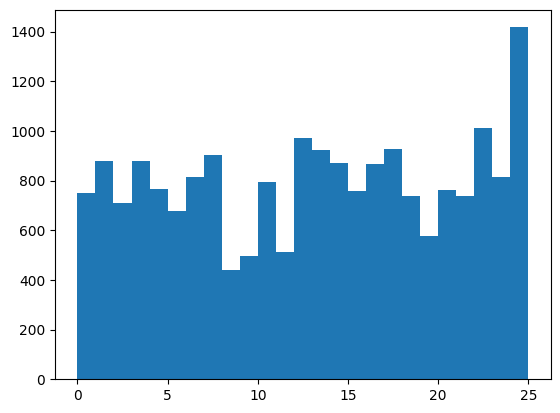

In [10]:
_ = plt.hist(train_subset.dataset.labels, bins=list(range(0, n_classes)))

In [11]:
BATCH_SIZE = 64

train_dl = DataLoader(train_subset, batch_size = BATCH_SIZE, shuffle = True)
val_dl   = DataLoader(validation_subset, batch_size = BATCH_SIZE, shuffle = False)

## Model

In [44]:
from torch.nn import Linear, ReLU, CrossEntropyLoss, Conv2d, MaxPool2d, Module, BatchNorm2d
from torch.optim import Adam
import torch.nn.functional as F

class AlexCaptchaNet(Module):   
    def __init__(self):
        """
        Конструктор для создания слоев модели.
        """
        super(AlexCaptchaNet, self).__init__()
        
        # First convolutional layer
        self.conv1 = Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0)
        self.batchnorm1 = BatchNorm2d(96)
        self.maxpool = MaxPool2d(kernel_size=3, stride=2)
        
        # Second convolutional layer
        self.conv2 = Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.batchnorm2 = BatchNorm2d(256)
        
        # 3rd convolutional layer
        self.conv3 = Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = BatchNorm2d(384)
        
        # 4th сверточный слой
        self.conv4 = Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.batchnorm4 = BatchNorm2d(384)
        
        # 5th сверточный слой
        self.conv5 = Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.batchnorm5 = BatchNorm2d(256)
        
        # Fully connected layers
        self.fc1 = Linear(in_features=9216, out_features=4096)
        self.fc2 = Linear(in_features=4096, out_features=4096)
        self.fc3 = Linear(in_features=4096, out_features=n_classes)  # n_classes = 26

    def forward(self, x):
        """
        Прямое распространение (forward pass).
        
        :param x: Входной тензор
        :return: Выходной тензор
        """
        x = F.relu(self.conv1(x.float()))  # Applying the first convolutional layer and ReLU
        x = self.batchnorm1(x)             # Applying Batch Normalization
        x = self.maxpool(x)                # Application of Max Pooling
        
        x = F.relu(self.conv2(x))
        x = self.batchnorm2(x)
        x = self.maxpool(x)
        
        x = F.relu(self.conv3(x))
        x = self.batchnorm3(x)
        
        x = F.relu(self.conv4(x))
        x = self.batchnorm4(x)
        
        x = F.relu(self.conv5(x))
        x = self.batchnorm5(x)
        x = self.maxpool(x)
        
        x = x.reshape(x.shape[0], -1)      # Tensor alignment
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [13]:
model = AlexCaptchaNet()

## Predict

In [15]:
LEARNING_RATE = 1e-4
EPOCH_NUM = 1

In [ ]:
# Send the model to the device for training - CPU
device='cpu'
model = model.to(device='cpu')

# Set the loss function and optimizer
learning_rate = LEARNING_RATE
criterion = CrossEntropyLoss()                          # Cross-entropy loss function
optimizer = Adam(model.parameters(), lr=learning_rate)  # Adam Optimizer

# Learning cycle
for epoch in range(EPOCH_NUM):
    loss_ep = 0
    
    # Training on the training data set
    for batch_idx, (data, targets) in enumerate(train_dl):
        data = data.to(device='cpu')
        targets = targets.to(device='cpu')
        
        optimizer.zero_grad()
        scores = model(data)               # Forward pass
        loss = criterion(scores, targets)  # Calculating losses
        loss.backward()                    # Backward pass
        optimizer.step()                   # Update model parameters
        
        loss_ep += loss.item()
        
    # Display the average losses per epoch
    print(f"Loss in epoch {epoch} :: {loss_ep / len(train_dl)}")

    # Model evaluation on a validation dataset
    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        
        for batch_idx, (data, targets) in enumerate(val_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            
            scores = model(data)
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()  # Count the number of correct predictions
            num_samples += predictions.size(0)             # Count the number of samples
        
        # Display the accuracy of the model
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )

Loss in epoch 0 :::: 0.40191447561979293
Got 3364 / 4000 with accuracy 84.10


In [ ]:
torch.save(model.state_dict(), './model.pth')

## Test before submission

In [ ]:
model.load_state_dict(torch.load('model.pth'))

In [ ]:
dataset_for_final = NpyImagesDataset('/kaggle/input/captcha/mds-misis-dl-captchan/images_sub.npy', '', image_transformation)
submission_dl = DataLoader(dataset_for_final, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
submission_resuls = []

for batch_idx, (data, targets) in enumerate(submission_dl):
    scores = model(data.cpu())
    softmax = torch.exp(scores).cpu()
    prob = list(softmax.detach().numpy())
    predictions = np.argmax(prob, axis=1)
    submission_resuls.append(predictions)

In [ ]:
import pandas as pd 

# Write data to submission file
sample_submission = pd.read_csv('/kaggle/input/captcha/mds-misis-dl-captchan/sample_submission.csv')
sample_submission.head()

sample_submission['Category'] = np.concatenate(submission_resuls)
sample_submission.to_csv('captcha_submission.csv', index=False)
sample_submission.head(10)